In [ ]:
!pip install stable-baselines3 pandas openpyxl gym numpy matplotlib
!pip install gymnasium shimmy
!pip install gymnasium[all]
!pip install --upgrade stable-baselines3



  Using cached ale_py-0.10.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.6 kB)
  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Using cached swig-4.3.0-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl.metadata (3.5 kB)
  Using cached mujoco_py-2.1.2.14-py3-none-any.whl.metadata (669 bytes)
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl.metadata (3.1 kB)
  Using cached mujoco-3.2.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (44 kB)
  Using cached glfw-2.8.0-py2.py27.py3.py30.py31.py32.py33.py34.py35.py36.py37.py38.p39.p310.p311.p312.p313-none-manylinux_2_28_x86_64.whl.metadata (5.4 kB)
  Using cached fasteners-0.19-py3-none-any.whl.metadata (4.9 kB)
Using cached swig-4.3.0-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.9 MB)
Using cached ale_py-0.10.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.1 

In [ ]:
import pandas as pd
import os
import numpy as np

# Excel fájl betöltése
file_path = 'heti_zaro.xlsx'
excel_data = pd.ExcelFile(file_path)

# Kovariancia mátrix
output_dir = 'covariance_matrices_weekly_test'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Heti hozamok számítása
def calculate_weekly_log_returns(data):

    numeric_data = data.select_dtypes(include=[np.number])
    return np.log(numeric_data / numeric_data.shift(1)).dropna()

# Feldolgozás minden munkalapra az Excel fájlban
for sheet_name in excel_data.sheet_names:
    # Munkalap betöltése DataFrame-be
    weekly_data = excel_data.parse(sheet_name)

    # Loghozamok számítása
    weekly_log_returns = calculate_weekly_log_returns(weekly_data)

    if weekly_log_returns.empty:
        print(f"A(z) {sheet_name} munkalap kihagyva, mert nincs érvényes numerikus adat.")
        continue

    # Kovariancia mátrix számítása
    covariance_matrix = weekly_log_returns.cov()

    # Csak a dátum rész kivonása a munkalap nevéből
    date_only = sheet_name.split(" ")[0] if " " in sheet_name else sheet_name

    # Kovariancia mátrix mentése CSV fájlba
    output_file = os.path.join(output_dir, f'cov_matrix_{date_only}.csv')
    covariance_matrix.to_csv(output_file)

print(f"Minden heti kovariancia mátrix sikeresen mentve a(z) {output_dir} mappába.")


Covariance matrices for all weeks have been successfully saved to covariance_matrices_weekly_test.


In [ ]:
import yfinance as yf
import pandas as pd

# Részvények listája
tickers = ["AAPL", "TXN", "NVDA", "AVGO", "ISRG", "CSX", "EBAY", "MCHP", "TSLA"]

# Időszak a Yahoo Finance lekérdezéshez
start_date = "2023-06-26"
end_date = "2024-07-08"

def fetch_and_save_weekly_prices_fixed_dates(tickers, start_date, end_date, output_file):
    # Heti időindex generálása 2023-07-03-tól kezdve
    date_range = pd.date_range(start=start_date, end=end_date, freq='7D')

    # Üres DataFrame előkészítése az időindex alapján
    all_data = pd.DataFrame(index=date_range)

    for ticker in tickers:
        print(f"Adatok letöltése: {ticker}")
        stock_data = yf.download(ticker, start=start_date, end=end_date, interval="1d")

        if stock_data.empty:
            print(f"Nincs adat a(z) {ticker} részvényhez.")
            continue

        # Timestamp eltávolítása
        stock_data.index = stock_data.index.date

        print(f"Letöltött adatok a {ticker} részvényhez (első 5 sor):")
        print(stock_data.head())

        # Heti adatok feldolgozása (hétfő vagy kedd)
        weekly_data = []
        for monday in date_range:
            if monday.date() in stock_data.index:
                close_price = stock_data.loc[monday.date()]['Close']
            else:
                tuesday = monday + pd.Timedelta(days=1)
                if tuesday.date() in stock_data.index:
                    close_price = stock_data.loc[tuesday.date()]['Close']
                else:
                    close_price = None  # Ha sem hétfő, sem kedd nincs

            # Csak az árfolyam értéke kerül be
            weekly_data.append(float(close_price) if close_price is not None else None)

        # Az adott részvény adatait hozzáadjuk a fő DataFrame-hez
        all_data[ticker] = weekly_data

    print("Feldolgozott heti záróárfolyamok:")
    print(all_data.head())  # Az első pár sor megjelenítése az összesített adatokból

    # Eredmény mentése Excel-fájlba
    all_data.to_excel(output_file)
    print(f"Heti záróárfolyamok mentése kész: {output_file}")

# Fájl mentési útvonala
output_file = "weekly_closing_prices_fixed_values.xlsx"

# Adatok letöltése és mentése Excel-be
fetch_and_save_weekly_prices_fixed_dates(tickers, start_date, end_date, output_file)


[*********************100%***********************]  1 of 1 completed
<ipython-input-90-3a7e440ed9e7>:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  weekly_data.append(float(close_price) if close_price is not None else None)
[*********************100%***********************]  1 of 1 completed

Adatok letöltése: AAPL
Letöltött adatok a AAPL részvényhez (első 5 sor):
Price        Adj Close       Close        High         Low        Open  \
Ticker            AAPL        AAPL        AAPL        AAPL        AAPL   
2023-06-26  183.875900  185.270004  188.050003  185.229996  186.830002   
2023-06-27  186.644928  188.059998  188.389999  185.669998  185.889999   
2023-06-28  187.825958  189.250000  189.899994  187.600006  187.929993   
2023-06-29  188.163361  189.589996  190.070007  188.940002  189.080002   
2023-06-30  192.510422  193.970001  194.479996  191.259995  191.630005   

Price         Volume  
Ticker          AAPL  
2023-06-26  48088700  
2023-06-27  50730800  
2023-06-28  51216800  
2023-06-29  46347300  
2023-06-30  85069600  
Adatok letöltése: TXN
Letöltött adatok a TXN részvényhez (első 5 sor):
Price        Adj Close       Close        High         Low        Open  \
Ticker             TXN         TXN         TXN         TXN         TXN   
2023-06-26  161.450546  168.


<ipython-input-90-3a7e440ed9e7>:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  weekly_data.append(float(close_price) if close_price is not None else None)
[*********************100%***********************]  1 of 1 completed
<ipython-input-90-3a7e440ed9e7>:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  weekly_data.append(float(close_price) if close_price is not None else None)
[*********************100%***********************]  1 of 1 completed
<ipython-input-90-3a7e440ed9e7>:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  weekly_data.append(float(close_price) if close_price is not None else None)


Letöltött adatok a NVDA részvényhez (első 5 sor):
Price       Adj Close      Close       High        Low       Open     Volume
Ticker           NVDA       NVDA       NVDA       NVDA       NVDA       NVDA
2023-06-26  40.616367  40.632000  42.764000  40.099998  42.460999  594322000
2023-06-27  41.859882  41.875999  41.939999  40.448002  40.799000  462175000
2023-06-28  41.101177  41.117001  41.845001  40.518002  40.660000  582639000
2023-06-29  40.806290  40.821999  41.599998  40.599998  41.557999  380514000
2023-06-30  42.285721  42.301998  42.549999  41.500999  41.680000  501148000
Adatok letöltése: AVGO
Letöltött adatok a AVGO részvényhez (első 5 sor):
Price       Adj Close      Close       High        Low       Open    Volume
Ticker           AVGO       AVGO       AVGO       AVGO       AVGO      AVGO
2023-06-26  80.477875  82.163002  83.699997  82.022003  82.500000  21372000
2023-06-27  83.099968  84.839996  85.000000  82.099998  82.867996  24923000
2023-06-28  83.054901  84.793999  

[*********************100%***********************]  1 of 1 completed
<ipython-input-90-3a7e440ed9e7>:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  weekly_data.append(float(close_price) if close_price is not None else None)


Adatok letöltése: ISRG
Letöltött adatok a ISRG részvényhez (első 5 sor):
Price        Adj Close       Close        High         Low        Open  \
Ticker            ISRG        ISRG        ISRG        ISRG        ISRG   
2023-06-26  325.160004  325.160004  328.429993  323.230011  326.600006   
2023-06-27  330.019989  330.019989  330.989990  325.290009  329.510010   
2023-06-28  332.980011  332.980011  334.510010  329.480011  330.000000   
2023-06-29  338.489990  338.489990  340.589996  334.609985  335.000000   
2023-06-30  341.940002  341.940002  344.079987  340.570007  341.329987   

Price        Volume  
Ticker         ISRG  
2023-06-26  1309300  
2023-06-27  1268100  
2023-06-28  1089000  
2023-06-29  1679300  
2023-06-30  1506100  
Adatok letöltése: CSX


[*********************100%***********************]  1 of 1 completed
<ipython-input-90-3a7e440ed9e7>:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  weekly_data.append(float(close_price) if close_price is not None else None)
[*********************100%***********************]  1 of 1 completed
<ipython-input-90-3a7e440ed9e7>:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  weekly_data.append(float(close_price) if close_price is not None else None)


Letöltött adatok a CSX részvényhez (első 5 sor):
Price       Adj Close      Close       High        Low       Open   Volume
Ticker            CSX        CSX        CSX        CSX        CSX      CSX
2023-06-26  32.434074  33.110001  33.270000  32.740002  32.799999  8464900
2023-06-27  32.786728  33.470001  33.650002  33.139999  33.139999  8861600
2023-06-28  32.904270  33.590000  33.630001  33.380001  33.480000  9303800
2023-06-29  33.178562  33.869999  33.869999  33.340000  33.439999  6311200
2023-06-30  33.403862  34.099998  34.180000  33.709999  34.000000  9416300
Adatok letöltése: EBAY
Letöltött adatok a EBAY részvényhez (első 5 sor):
Price       Adj Close      Close       High        Low       Open   Volume
Ticker           EBAY       EBAY       EBAY       EBAY       EBAY     EBAY
2023-06-26  42.133274  43.459999  43.759998  43.259998  43.459999  3551500
2023-06-27  43.112442  44.470001  44.549999  43.480000  43.580002  4758900
2023-06-28  43.471146  44.840000  44.849998  44.24000

[*********************100%***********************]  1 of 1 completed
<ipython-input-90-3a7e440ed9e7>:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  weekly_data.append(float(close_price) if close_price is not None else None)
[*********************100%***********************]  1 of 1 completed
<ipython-input-90-3a7e440ed9e7>:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  weekly_data.append(float(close_price) if close_price is not None else None)


Letöltött adatok a MCHP részvényhez (első 5 sor):
Price       Adj Close      Close       High        Low       Open   Volume
Ticker           MCHP       MCHP       MCHP       MCHP       MCHP     MCHP
2023-06-26  80.164009  82.839996  83.830002  82.230003  82.389999  3685900
2023-06-27  83.976738  86.779999  87.080002  82.900002  83.120003  4904300
2023-06-28  83.105804  85.879997  86.959999  85.589996  85.800003  4151400
2023-06-29  84.170280  86.980003  87.269997  85.779999  86.379997  3455100
2023-06-30  86.695961  89.589996  90.050003  87.959999  88.269997  5289600
Adatok letöltése: TSLA
Letöltött adatok a TSLA részvényhez (első 5 sor):
Price        Adj Close       Close        High         Low        Open  \
Ticker            TSLA        TSLA        TSLA        TSLA        TSLA   
2023-06-26  241.050003  241.050003  258.369995  240.699997  250.070007   
2023-06-27  250.210007  250.210007  250.389999  240.850006  243.240005   
2023-06-28  256.239990  256.239990  259.880005  248.8899

In [ ]:
import pandas as pd
import numpy as np

def calculate_and_save_log_returns(input_file, output_file):
    # Heti záróárfolyamok betöltése az Excel fájlból
    data = pd.read_excel(input_file, index_col=0)

    # Loghozamok kiszámítása
    log_returns = np.log(data / data.shift(1))

    # Csak a megadott dátumtartományt szűrjük ki (2023-07-03 és 2024-06-24 közötti adatok)
    start_date = "2023-07-03"
    end_date = "2024-06-24"
    log_returns = log_returns.loc[start_date:end_date]

    # Dátum konvertálása egyszerű formátumra (csak dátum, idő nélkül)
    log_returns.index = pd.to_datetime(log_returns.index).date

    # Loghozamok mentése egy új Excel fájlba
    log_returns.to_excel(output_file, index_label="Date")
    print(f"Loghozamok mentése kész: {output_file}")

# Fájlok megadása
input_file = "weekly_closing_prices_fixed_values.xlsx"
output_file = "weekly_log_returns_train.xlsx"

# Loghozamok kiszámítása és mentése
calculate_and_save_log_returns(input_file, output_file)


Loghozamok mentése kész: weekly_log_returns_train.xlsx


In [ ]:
import yfinance as yf
import pandas as pd

# Részvények listája
tickers = ["AAPL", "TXN", "NVDA", "AVGO", "ISRG", "CSX", "EBAY", "MCHP", "TSLA"]

# Időszak a Yahoo Finance lekérdezéshez
start_date = "2022-06-27"  # 52 héttel korábban kezdve a 2023-07-03 dátumtól
end_date = "2024-07-08"  # A kívánt intervallum végéig

def fetch_weekly_prices_to_excel(tickers, start_date, end_date, output_file):
    # Heti időindex generálása 2022-07-04-től kezdve
    date_range = pd.date_range(start=start_date, end=end_date, freq='7D')

    # Üres DataFrame előkészítése az időindex alapján
    all_data = pd.DataFrame(index=date_range)

    for ticker in tickers:
        print(f"Adatok letöltése: {ticker}")
        stock_data = yf.download(ticker, start=start_date, end=end_date, interval="1d")

        if stock_data.empty:
            print(f"Nincs adat a(z) {ticker} részvényhez.")
            continue

        # Timestamp eltávolítása
        stock_data.index = stock_data.index.date

        print(f"Letöltött adatok a {ticker} részvényhez (első 5 sor):")
        print(stock_data.head())

        # Heti adatok feldolgozása (hétfő vagy kedd)
        weekly_close_prices = []
        for monday in date_range:
            if monday.date() in stock_data.index:
                close_price = stock_data.loc[monday.date()]['Close']
            else:
                tuesday = monday + pd.Timedelta(days=1)
                if tuesday.date() in stock_data.index:
                    close_price = stock_data.loc[tuesday.date()]['Close']
                else:
                    close_price = None  # Ha sem hétfő, sem kedd nincs

            # Csak az árfolyam értéke kerül be
            weekly_close_prices.append(float(close_price) if close_price is not None else None)

        # Az adott részvény adatait hozzáadjuk a fő DataFrame-hez
        all_data[ticker] = weekly_close_prices

    print("Feldolgozott heti záróárfolyamok:")
    print(all_data.head())  # Az első pár sor megjelenítése az összesített adatokból

    # Eredmény mentése Excel-fájlba
    all_data.index = all_data.index.date  # Csak dátumot tároljunk timestamp nélkül
    all_data.to_excel(output_file)
    print(f"Heti záróárfolyamok mentése kész: {output_file}")

# Fájl mentési útvonala
output_file = "weekly_prices.xlsx"

# Adatok letöltése és mentése Excel-be
fetch_weekly_prices_to_excel(tickers, start_date, end_date, output_file)


[*********************100%***********************]  1 of 1 completed
<ipython-input-92-2e80d7124cdc>:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  weekly_close_prices.append(float(close_price) if close_price is not None else None)
[*********************100%***********************]  1 of 1 completed

Adatok letöltése: AAPL
Letöltött adatok a AAPL részvényhez (első 5 sor):
Price        Adj Close       Close        High         Low        Open  \
Ticker            AAPL        AAPL        AAPL        AAPL        AAPL   
2022-06-27  139.759521  141.660004  143.490005  140.970001  142.699997   
2022-06-28  135.596130  137.440002  143.419998  137.320007  142.130005   
2022-06-29  137.362137  139.229996  140.669998  136.669998  137.460007   
2022-06-30  134.885773  136.720001  138.369995  133.770004  137.250000   
2022-07-01  137.066116  138.929993  139.039993  135.660004  136.039993   

Price         Volume  
Ticker          AAPL  
2022-06-27  70207900  
2022-06-28  67083400  
2022-06-29  66242400  
2022-06-30  98964500  
2022-07-01  71051600  
Adatok letöltése: TXN
Letöltött adatok a TXN részvényhez (első 5 sor):
Price        Adj Close       Close        High         Low        Open  \
Ticker             TXN         TXN         TXN         TXN         TXN   
2022-06-27  144.592651  155.


<ipython-input-92-2e80d7124cdc>:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  weekly_close_prices.append(float(close_price) if close_price is not None else None)
[*********************100%***********************]  1 of 1 completed
<ipython-input-92-2e80d7124cdc>:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  weekly_close_prices.append(float(close_price) if close_price is not None else None)
[*********************100%***********************]  1 of 1 completed
<ipython-input-92-2e80d7124cdc>:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  weekly_close_prices.append(float(close_price) if close_price is not None else None)


Letöltött adatok a NVDA részvényhez (első 5 sor):
Price       Adj Close      Close    High        Low    Open     Volume
Ticker           NVDA       NVDA    NVDA       NVDA    NVDA       NVDA
2022-06-27  16.848583  16.868999  17.330  16.625999  17.312  427968000
2022-06-28  15.962657  15.982000  17.202  15.945000  16.900  461149000
2022-06-29  15.523189  15.542000  15.820  15.170000  15.814  482352000
2022-06-30  15.140651  15.159000  15.567  14.862000  15.361  686070000
2022-07-01  14.505422  14.523000  15.063  14.392000  14.899  577610000
Adatok letöltése: AVGO
Letöltött adatok a AVGO részvényhez (első 5 sor):
Price       Adj Close      Close       High        Low       Open    Volume
Ticker           AVGO       AVGO       AVGO       AVGO       AVGO      AVGO
2022-06-27  48.111004  50.570999  51.403999  50.282001  51.380001  13207000
2022-06-28  47.420322  49.845001  51.415001  49.811001  51.261002  15667000
2022-06-29  46.655430  49.041000  49.592999  48.667000  49.548000  14444000


[*********************100%***********************]  1 of 1 completed
<ipython-input-92-2e80d7124cdc>:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  weekly_close_prices.append(float(close_price) if close_price is not None else None)


Letöltött adatok a ISRG részvényhez (első 5 sor):
Price        Adj Close       Close        High         Low        Open  \
Ticker            ISRG        ISRG        ISRG        ISRG        ISRG   
2022-06-27  207.940002  207.940002  209.880005  205.880005  208.800003   
2022-06-28  201.990005  201.990005  211.470001  201.169998  209.020004   
2022-06-29  202.589996  202.589996  203.850006  197.850006  201.850006   
2022-06-30  200.710007  200.710007  203.380005  197.610001  201.460007   
2022-07-01  206.100006  206.100006  206.330002  200.000000  201.070007   

Price        Volume  
Ticker         ISRG  
2022-06-27  1900800  
2022-06-28  1662000  
2022-06-29  1655400  
2022-06-30  2224300  
2022-07-01  1459700  
Adatok letöltése: CSX


[*********************100%***********************]  1 of 1 completed
<ipython-input-92-2e80d7124cdc>:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  weekly_close_prices.append(float(close_price) if close_price is not None else None)
[*********************100%***********************]  1 of 1 completed
<ipython-input-92-2e80d7124cdc>:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  weekly_close_prices.append(float(close_price) if close_price is not None else None)


Letöltött adatok a CSX részvényhez (első 5 sor):
Price       Adj Close      Close       High        Low       Open    Volume
Ticker            CSX        CSX        CSX        CSX        CSX       CSX
2022-06-27  28.339689  29.320000  29.639999  29.059999  29.590000  16602400
2022-06-28  28.165710  29.139999  30.139999  29.080000  29.820000  13123200
2022-06-29  28.146378  29.120001  29.290001  28.700001  29.290001  17330100
2022-06-30  28.088383  29.059999  29.240000  28.580000  28.940001  16745500
2022-07-01  28.359022  29.340000  29.540001  28.830000  29.090000  13838800
Adatok letöltése: EBAY
Letöltött adatok a EBAY részvényhez (első 5 sor):
Price       Adj Close      Close       High        Low       Open   Volume
Ticker           EBAY       EBAY       EBAY       EBAY       EBAY     EBAY
2022-06-27  42.113686  44.380001  45.939999  44.220001  45.869999  4703400
2022-06-28  40.472038  42.650002  44.480000  42.599998  43.400002  5435600
2022-06-29  40.491009  42.669998  43.029999  4

[*********************100%***********************]  1 of 1 completed
<ipython-input-92-2e80d7124cdc>:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  weekly_close_prices.append(float(close_price) if close_price is not None else None)
[*********************100%***********************]  1 of 1 completed
<ipython-input-92-2e80d7124cdc>:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  weekly_close_prices.append(float(close_price) if close_price is not None else None)


Letöltött adatok a MCHP részvényhez (első 5 sor):
Price       Adj Close      Close       High        Low       Open   Volume
Ticker           MCHP       MCHP       MCHP       MCHP       MCHP     MCHP
2022-06-27  57.675430  60.669998  61.410000  60.090000  61.349998  3145700
2022-06-28  56.515652  59.450001  62.919998  59.389999  62.180000  9588400
2022-06-29  55.184746  58.049999  59.060001  57.310001  58.770000  3981700
2022-06-30  55.213272  58.080002  59.080002  56.549999  57.200001  5327300
2022-07-01  53.388039  56.160000  57.990002  55.290001  57.200001  4657500
Adatok letöltése: TSLA
Letöltött adatok a TSLA részvényhez (első 5 sor):
Price        Adj Close       Close        High         Low        Open  \
Ticker            TSLA        TSLA        TSLA        TSLA        TSLA   
2022-06-27  244.919998  244.919998  252.070007  242.566666  249.366669   
2022-06-28  232.663330  232.663330  249.970001  232.343338  244.483337   
2022-06-29  228.490005  228.490005  231.173340  222.2733

In [ ]:
import pandas as pd
import numpy as np

def calculate_weekly_log_returns(input_file, output_file):
    # Az adatok betöltése az Excel fájlból
    weekly_prices = pd.read_excel(input_file, index_col=0)
    weekly_prices.index = pd.to_datetime(weekly_prices.index)  # Dátumként kezeljük az indexet

    # Loghozamok kiszámítása
    log_returns = np.log(weekly_prices / weekly_prices.shift(1))

    # Csak a 2022-07-03 és 2024-07-01 közötti adatokat tartsuk meg
    filtered_log_returns = log_returns.loc["2022-07-03":"2024-07-01"]

    # Csak dátumokat tároljunk az indexben, timestamp nélkül
    filtered_log_returns.index = filtered_log_returns.index.date

    # Az eredmények mentése Excel-fájlba
    filtered_log_returns.to_excel(output_file)
    print(f"Heti loghozamok mentése kész: {output_file}")

# Input és output fájlnevek
input_file = "weekly_prices.xlsx"
output_file = "weekly_log_returns_train_2022.xlsx"

# Loghozamok kiszámítása és mentése
calculate_weekly_log_returns(input_file, output_file)


Heti loghozamok mentése kész: weekly_log_returns_train_2022.xlsx


In [ ]:
import pandas as pd
import os

def calculate_weekly_covariance_matrices(input_file, output_dir):
    # Az adatok betöltése az Excel fájlból
    log_returns = pd.read_excel(input_file, index_col=0)
    log_returns.index = pd.to_datetime(log_returns.index)  # Dátumként kezeljük az indexet

    # Ellenőrizzük, hogy az output könyvtár létezik-e, ha nem, létrehozzuk
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Az első hét kezdőnapja és az utolsó hét kezdőnapja
    start_date = pd.Timestamp("2023-07-03")
    end_date = pd.Timestamp("2024-06-28")

    # Hetente iterálva számítjuk ki a kovariancia mátrixokat
    current_date = start_date
    while current_date <= end_date:
        # A 52 hetes intervallum kiszámítása
        start_interval = current_date - pd.Timedelta(weeks=52)
        interval_data = log_returns.loc[start_interval:current_date]

        # Ha az intervallumban nincs elegendő adat, kihagyjuk
        if interval_data.isna().sum().sum() > 0 or interval_data.empty:
            print(f"Nincs elég adat a kovariancia mátrixhoz: {current_date.date()}")
            current_date += pd.Timedelta(weeks=1)
            continue

        # Kovariancia mátrix számítása
        cov_matrix = interval_data.cov()

        # CSV fájl mentése
        output_file = os.path.join(output_dir, f"cov_matrix_{current_date.date()}.csv")
        cov_matrix.to_csv(output_file)
        print(f"Kovariancia mátrix mentve: {output_file}")

        # Következő hét
        current_date += pd.Timedelta(weeks=1)

# Input és output fájlok
input_file = "weekly_log_returns_train_2022.xlsx"
output_dir = "covariance_matrices_train"

# Kovariancia mátrixok számítása és mentése
calculate_weekly_covariance_matrices(input_file, output_dir)


Kovariancia mátrix mentve: covariance_matrices_train/cov_matrix_2023-07-03.csv
Kovariancia mátrix mentve: covariance_matrices_train/cov_matrix_2023-07-10.csv
Kovariancia mátrix mentve: covariance_matrices_train/cov_matrix_2023-07-17.csv
Kovariancia mátrix mentve: covariance_matrices_train/cov_matrix_2023-07-24.csv
Kovariancia mátrix mentve: covariance_matrices_train/cov_matrix_2023-07-31.csv
Kovariancia mátrix mentve: covariance_matrices_train/cov_matrix_2023-08-07.csv
Kovariancia mátrix mentve: covariance_matrices_train/cov_matrix_2023-08-14.csv
Kovariancia mátrix mentve: covariance_matrices_train/cov_matrix_2023-08-21.csv
Kovariancia mátrix mentve: covariance_matrices_train/cov_matrix_2023-08-28.csv
Kovariancia mátrix mentve: covariance_matrices_train/cov_matrix_2023-09-04.csv
Kovariancia mátrix mentve: covariance_matrices_train/cov_matrix_2023-09-11.csv
Kovariancia mátrix mentve: covariance_matrices_train/cov_matrix_2023-09-18.csv
Kovariancia mátrix mentve: covariance_matrices_train

In [ ]:
import os
import numpy as np
import pandas as pd
from gym import Env, spaces
from stable_baselines3 import PPO

# RL környezet definiálása
class OptimizedPortfolioEnv(Env):
    def __init__(self, log_returns, cov_dir):
        super(OptimizedPortfolioEnv, self).__init__()
        self.log_returns = log_returns
        self.cov_dir = cov_dir
        self.current_week = 0
        self.tickers = log_returns.columns

        # Kovarianciamátrix fájlok
        self.cov_files = sorted(
            [f for f in os.listdir(cov_dir) if f.startswith("cov_matrix_") and f.endswith(".csv")]
        )
        if not self.cov_files:
            raise FileNotFoundError(f"Nincs kovarianciamátrix a megadott könyvtárban: {cov_dir}")

        # Akciótér: részvények súlyai
        self.action_space = spaces.Box(low=0.01, high=0.99, shape=(len(self.tickers),), dtype=np.float32)

        # Állapottér: loghozamok és lapított kovarianciamátrix
        obs_dim = len(self.tickers) + len(self.tickers) ** 2
        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(obs_dim,),
            dtype=np.float32
        )

    def reset(self):
        self.current_week = 0
        return self._get_observation()

    def step(self, action):
        if self.current_week >= len(self.log_returns):
            done = True
            return self._get_observation(), 0, done, {}

        # Súlyok normalizálása a korlátoknak megfelelően
        action_sum = np.sum(action)
        portfolio_weights = action / action_sum if action_sum > 0 else np.ones_like(action) / len(action)

        # Aktuális loghozamok
        current_log_returns = self.log_returns.iloc[self.current_week]

        # Kovarianciamátrix betöltése
        cov_matrix_path = os.path.join(self.cov_dir, self.cov_files[self.current_week])
        if not os.path.exists(cov_matrix_path):
            raise FileNotFoundError(f"Nem található kovarianciamátrix: {cov_matrix_path}")

        current_cov_matrix = pd.read_csv(cov_matrix_path, index_col=0)

        # Jutalom számítása (Sharpe-mutató)
        expected_return = np.dot(current_log_returns, portfolio_weights)
        portfolio_variance = np.dot(portfolio_weights.T, np.dot(current_cov_matrix.values, portfolio_weights))
        sharpe_ratio = expected_return / np.sqrt(portfolio_variance)
        reward = sharpe_ratio

        self.current_week += 1
        done = self.current_week >= len(self.log_returns)

        return self._get_observation(), reward, done, {}

    def _get_observation(self):
        if self.current_week >= len(self.log_returns):
            return np.zeros(self.observation_space.shape)

        current_log_returns = self.log_returns.iloc[self.current_week]

        cov_matrix_path = os.path.join(self.cov_dir, self.cov_files[self.current_week])
        if not os.path.exists(cov_matrix_path):
            raise FileNotFoundError(f"Nem található kovarianciamátrix: {cov_matrix_path}")

        current_cov_matrix = pd.read_csv(cov_matrix_path, index_col=0)

        return np.concatenate([current_log_returns.values, current_cov_matrix.values.flatten()])

# Train és Test környezet inicializálása
train_log_returns_file = 'weekly_log_returns_train.xlsx'
train_cov_dir = 'covariance_matrices_train'

test_log_returns_file = 'heti_log.xlsx'
test_cov_dir = 'covariance_matrices_weekly_test'

train_log_returns = pd.read_excel(train_log_returns_file, index_col=0)
test_log_returns = pd.read_excel(test_log_returns_file, index_col=0)

train_env = OptimizedPortfolioEnv(train_log_returns, train_cov_dir)
test_env = OptimizedPortfolioEnv(test_log_returns, test_cov_dir)

# PPO modell inicializálása
policy_kwargs = dict(net_arch=[128, 128])  # Többrétegű neurális hálózat
model = PPO(
    "MlpPolicy",
    train_env,
    learning_rate=1e-5,  # Alacsonyabb tanulási ráta
    gamma=0.995,  # Jövőbeli jutalmak nagyobb súlya
    n_steps=512,  # Hosszabb update lépések
    batch_size=128,  # Nagyobb batch méret
    policy_kwargs=policy_kwargs,
    verbose=1
)

# Modell tanítása
timesteps = 50000  # Hosszabb tanulási idő
model.learn(total_timesteps=timesteps)

# Modell mentése
model.save("optimized_ppo_portfolio")

# Tesztfázis
obs = test_env.reset()
done = False
weights_history = []
total_reward = 0
sharpe_ratios = []

while not done:
    action, _ = model.predict(obs)
    obs, reward, done, _ = test_env.step(action)
    weights_history.append(action / np.sum(action))  # Súlyok mentése
    total_reward += reward

    # Sharpe-mutató számítása
    current_log_returns = test_env.log_returns.iloc[test_env.current_week - 1]
    portfolio_weights = action / np.sum(action)
    expected_return = np.dot(current_log_returns, portfolio_weights)
    cov_matrix_path = os.path.join(test_cov_dir, test_env.cov_files[test_env.current_week - 1])
    current_cov_matrix = pd.read_csv(cov_matrix_path, index_col=0)
    portfolio_variance = np.dot(portfolio_weights.T, np.dot(current_cov_matrix.values, portfolio_weights))
    sharpe_ratios.append(expected_return / np.sqrt(portfolio_variance))

print(f"Teszt során elért összesített jutalom: {total_reward}")
print(f"Átlagos Sharpe-mutató: {np.mean(sharpe_ratios):.4f}")

# Részvénysúlyok táblázat mentése
weights_df = pd.DataFrame(
    weights_history,
    columns=test_env.tickers,
    index=test_env.log_returns.index[:len(weights_history)]
)
weights_df.to_excel("optimized_portfolio_weights.xlsx")
print(f"Részvénysúlyok mentése kész: optimized_portfolio_weights.xlsx")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 52       |
|    ep_rew_mean     | 8.74     |
| time/              |          |
|    fps             | 190      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 512      |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 52           |
|    ep_rew_mean          | 8.38         |
| time/                   |              |
|    fps                  | 180          |
|    iterations           | 2            |
|    time_elapsed         | 5            |
|    total_timesteps      | 1024         |
| train/                  |              |
|    approx_kl            | 7.367926e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -12.8        |
|    explained_variance   | -0.00427     |
|    learning_r

In [ ]:
# Modell metrikák értékelése
def evaluate_model_performance(test_env, weights_history, total_reward):
    print("\n=== Modell teljesítményének értékelése ===")

    # Teszthetek száma
    num_weeks = len(weights_history)

    # Átlagos heti jutalom
    avg_weekly_reward = total_reward / num_weeks

    # Várható hozamok és volatilitások kiszámítása
    expected_returns = []
    volatilities = []
    sharpe_ratios = []

    for week_idx in range(num_weeks):
        # Az aktuális loghozamok és portfólió súlyok
        log_returns = test_env.log_returns.iloc[week_idx]
        weights = weights_history[week_idx]

        # Kovarianciamátrix betöltése
        cov_matrix_path = os.path.join(test_env.cov_dir, test_env.cov_files[week_idx])
        current_cov_matrix = pd.read_csv(cov_matrix_path, index_col=0)

        # Várható hozam és volatilitás
        expected_return = np.dot(log_returns, weights)
        volatility = np.sqrt(np.dot(weights.T, np.dot(current_cov_matrix.values, weights)))

        # Sharpe-mutató
        sharpe_ratio = expected_return / volatility if volatility > 0 else 0

        # Eredmények mentése
        expected_returns.append(expected_return)
        volatilities.append(volatility)
        sharpe_ratios.append(sharpe_ratio)

    # Átlagos metrikák
    avg_expected_return = np.mean(expected_returns)
    avg_volatility = np.mean(volatilities)
    avg_sharpe_ratio = np.mean(sharpe_ratios)

    # Eredmények kiírása
    print(f"Összesített jutalom: {total_reward:.4f}")
    print(f"Átlagos heti jutalom: {avg_weekly_reward:.4f}")
    print(f"Átlagos várható hozam: {avg_expected_return:.4%}")
    print(f"Átlagos volatilitás: {avg_volatility:.4%}")
    print(f"Átlagos Sharpe-mutató: {avg_sharpe_ratio:.4f}")

    # Metrikák táblázatos formában
    metrics_df = pd.DataFrame({
        "Week": test_env.log_returns.index[:num_weeks],
        "Expected Return": expected_returns,
        "Volatility": volatilities,
        "Sharpe Ratio": sharpe_ratios
    })
    metrics_df.set_index("Week", inplace=True)
    metrics_df.to_excel("model_performance_metrics.xlsx")
    print(f"\nTeljesítmény metrikák mentve a 'model_performance_metrics.xlsx' fájlba.")

# Modell metrikák kiértékelése
evaluate_model_performance(test_env, weights_history, total_reward)



=== Modell teljesítményének értékelése ===
Összesített jutalom: 1.8748
Átlagos heti jutalom: 0.0852
Átlagos várható hozam: 0.0058%
Átlagos volatilitás: 3.7288%
Átlagos Sharpe-mutató: 0.0852

Teljesítmény metrikák mentve a 'model_performance_metrics.xlsx' fájlba.


Részvénysúlyok:
                AAPL       TXN      NVDA      AVGO      ISRG       CSX  \
Date                                                                     
2024-07-01  0.003160  0.022676  0.003160  0.246301  0.252357  0.153236   
2024-07-08  0.004381  0.106271  0.004381  0.433721  0.004381  0.433721   
2024-07-15  0.004185  0.004185  0.004185  0.004185  0.146212  0.414338   
2024-07-22  0.006994  0.006994  0.558682  0.392363  0.006994  0.006994   
2024-07-29  0.006321  0.277773  0.625732  0.006321  0.058572  0.006321   
2024-08-05  0.415146  0.005179  0.512684  0.005179  0.005179  0.005179   
2024-08-12  0.482927  0.004878  0.004878  0.004878  0.482927  0.004878   
2024-08-19  0.003297  0.055006  0.209245  0.003297  0.206985  0.189137   
2024-08-26  0.304760  0.005377  0.005377  0.005377  0.005377  0.130660   
2024-09-02  0.003074  0.003074  0.003074  0.262952  0.183803  0.208080   
2024-09-09  0.089976  0.053559  0.263599  0.003003  0.297313  0.209313   
2024-09-16  0.003132  

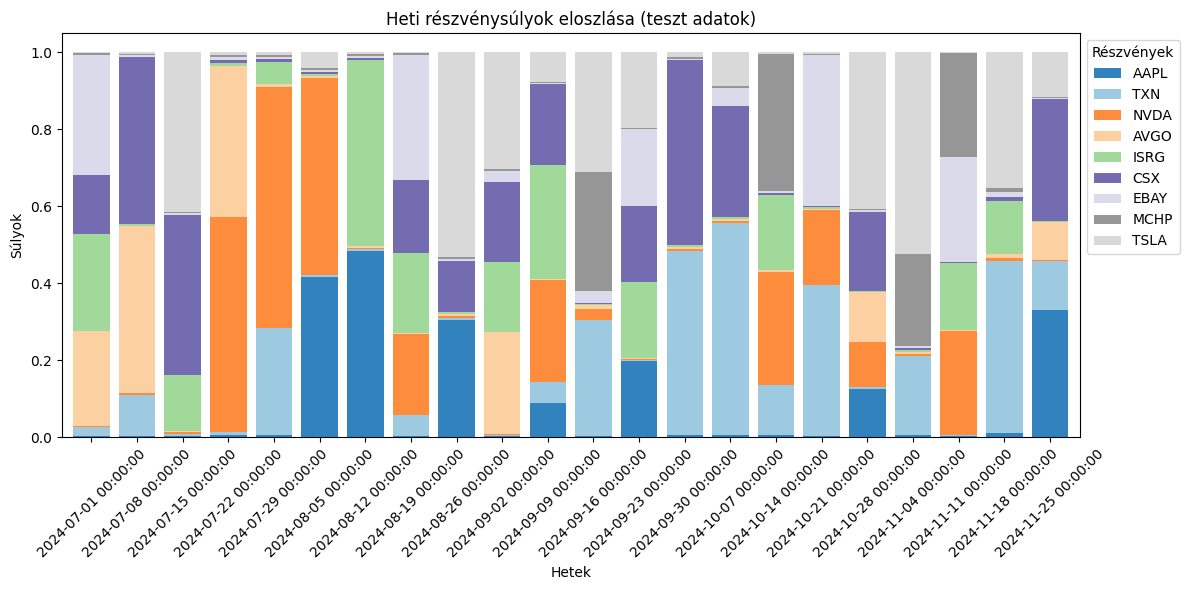

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Súlyok betöltése az Excel fájlból
weights_df = pd.read_excel("optimized_portfolio_weights.xlsx", index_col=0)

# Súlyok megjelenítése outputra
print("Részvénysúlyok:")
print(weights_df)

# Súlyok vizualizálása oszlopdiagramon
weights_df.plot(kind='bar', stacked=True, figsize=(12, 6), colormap="tab20c", width=0.8)
plt.title("Heti részvénysúlyok eloszlása (teszt adatok)")
plt.xlabel("Hetek")
plt.ylabel("Súlyok")
plt.xticks(rotation=45)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Részvények")
plt.tight_layout()

# Diagram mentése és megjelenítése
plt.savefig("optimized_portfolio_weights_chart.png")
plt.show()


In [ ]:
import os
import numpy as np
import pandas as pd
from gym import Env, spaces
from stable_baselines3 import PPO

# RL környezet definiálása
class OptimizedPortfolioEnv(Env):
    def __init__(self, log_returns, cov_dir):
        super(OptimizedPortfolioEnv, self).__init__()
        self.log_returns = log_returns
        self.cov_dir = cov_dir
        self.current_week = 0
        self.tickers = log_returns.columns

        # Kovarianciamátrix fájlok
        self.cov_files = sorted(
            [f for f in os.listdir(cov_dir) if f.startswith("cov_matrix_") and f.endswith(".csv")]
        )
        if not self.cov_files:
            raise FileNotFoundError(f"Nincs kovarianciamátrix a megadott könyvtárban: {cov_dir}")

        # Akciótér: részvények súlyai
        self.action_space = spaces.Box(low=0.01, high=0.99, shape=(len(self.tickers),), dtype=np.float32)

        # Állapottér: loghozamok és lapított kovarianciamátrix
        obs_dim = len(self.tickers) + len(self.tickers) ** 2
        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(obs_dim,),
            dtype=np.float32
        )

    def reset(self):
        self.current_week = 0
        return self._get_observation()

    def step(self, action):
        if self.current_week >= len(self.log_returns):
            done = True
            return self._get_observation(), 0, done, {}

        # Súlyok normalizálása
        action_sum = np.sum(action)
        portfolio_weights = action / action_sum if action_sum > 0 else np.ones_like(action) / len(action)

        # Aktuális loghozamok
        current_log_returns = self.log_returns.iloc[self.current_week]

        # Kovarianciamátrix betöltése
        cov_matrix_path = os.path.join(self.cov_dir, self.cov_files[self.current_week])
        if not os.path.exists(cov_matrix_path):
            raise FileNotFoundError(f"Nem található kovarianciamátrix: {cov_matrix_path}")

        current_cov_matrix = pd.read_csv(cov_matrix_path, index_col=0)

        # Jutalom számítása
        expected_return = np.dot(current_log_returns, portfolio_weights)
        portfolio_variance = np.dot(portfolio_weights.T, np.dot(current_cov_matrix.values, portfolio_weights))
        reward = expected_return / np.sqrt(portfolio_variance)  # Sharpe-mutató

        self.current_week += 1
        done = self.current_week >= len(self.log_returns)

        return self._get_observation(), reward, done, {}

    def _get_observation(self):
        if self.current_week >= len(self.log_returns):
            return np.zeros(self.observation_space.shape)

        current_log_returns = self.log_returns.iloc[self.current_week]

        cov_matrix_path = os.path.join(self.cov_dir, self.cov_files[self.current_week])
        if not os.path.exists(cov_matrix_path):
            raise FileNotFoundError(f"Nem található kovarianciamátrix: {cov_matrix_path}")

        current_cov_matrix = pd.read_csv(cov_matrix_path, index_col=0)

        return np.concatenate([current_log_returns.values, current_cov_matrix.values.flatten()])

# Train és Test környezet inicializálása
train_log_returns_file = 'weekly_log_returns_train.xlsx'
train_cov_dir = 'covariance_matrices_train'

test_log_returns_file = 'heti_log.xlsx'
test_cov_dir = 'covariance_matrices_weekly_test'

train_log_returns = pd.read_excel(train_log_returns_file, index_col=0)
test_log_returns = pd.read_excel(test_log_returns_file, index_col=0)

train_env = OptimizedPortfolioEnv(train_log_returns, train_cov_dir)
test_env = OptimizedPortfolioEnv(test_log_returns, test_cov_dir)

# Modell konfigurációk
models = {
    "Low Risk": PPO(
        "MlpPolicy",
        train_env,
        learning_rate=1e-5,
        gamma=0.995,
        n_steps=512,
        batch_size=128,
        policy_kwargs=dict(net_arch=[128, 128]),
        verbose=1
    ),
    "Balanced": PPO(
        "MlpPolicy",
        train_env,
        learning_rate=5e-5,
        gamma=0.99,
        n_steps=256,
        batch_size=128,
        policy_kwargs=dict(net_arch=[128, 128]),
        verbose=1
    ),
    "High Risk": PPO(
        "MlpPolicy",
        train_env,
        learning_rate=1e-4,
        gamma=0.98,
        n_steps=128,
        batch_size=64,
        policy_kwargs=dict(net_arch=[128, 128]),
        verbose=1
    )
}

# Modell tanítása és tesztelése
for name, model in models.items():
    print(f"--- {name.upper()} MODELL TRÉNING ---")
    model.learn(total_timesteps=50000)
    model.save(f"ppo_portfolio_{name.lower().replace(' ', '_')}")

    # Tesztfázis
    obs = test_env.reset()
    done = False
    weights_history = []
    total_reward = 0
    sharpe_ratios = []

    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, _ = test_env.step(action)
        weights_history.append(action / np.sum(action))
        total_reward += reward

        # Sharpe-mutató számítása
        current_log_returns = test_env.log_returns.iloc[test_env.current_week - 1]
        portfolio_weights = action / np.sum(action)
        expected_return = np.dot(current_log_returns, portfolio_weights)
        cov_matrix_path = os.path.join(test_cov_dir, test_env.cov_files[test_env.current_week - 1])
        current_cov_matrix = pd.read_csv(cov_matrix_path, index_col=0)
        portfolio_variance = np.dot(portfolio_weights.T, np.dot(current_cov_matrix.values, portfolio_weights))
        sharpe_ratios.append(expected_return / np.sqrt(portfolio_variance))

    # Eredmények kiírása
    print(f"--- {name.upper()} MODELL ÉRTÉKELÉSE ---")
    print(f"Összesített jutalom: {total_reward:.4f}")
    print(f"Átlagos Sharpe-mutató: {np.mean(sharpe_ratios):.4f}")

    # Súlyok mentése
    weights_df = pd.DataFrame(
        weights_history,
        columns=test_env.tickers,
        index=test_env.log_returns.index[:len(weights_history)]
    )
    weights_df.to_excel(f"portfolio_weights_{name.lower().replace(' ', '_')}.xlsx")
    print(f"Részvénysúlyok mentése kész: portfolio_weights_{name.lower().replace(' ', '_')}.xlsx")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
--- LOW RISK MODELL TRÉNING ---


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


A streamkimeneten csak az utolsó 5000 sor látható.
|    value_loss           | 8.46         |
------------------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 52            |
|    ep_rew_mean          | 14.9          |
| time/                   |               |
|    fps                  | 146           |
|    iterations           | 165           |
|    time_elapsed         | 143           |
|    total_timesteps      | 21120         |
| train/                  |               |
|    approx_kl            | 0.00091163255 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -12.8         |
|    explained_variance   | 0.227         |
|    learning_rate        | 0.0001        |
|    loss                 | 2.94          |
|    n_updates            | 1640          |
|    policy_gradient_loss | -0.00324      |
|    std                  |

In [ ]:
# Modell metrikák értékelése
def evaluate_model_performance(test_env, weights_history, total_reward, model_name):
    print(f"\n=== {model_name.upper()} MODELL TELJESÍTMÉNYÉNEK ÉRTÉKELÉSE ===")

    # Teszthetek száma
    num_weeks = len(weights_history)

    # Átlagos heti jutalom
    avg_weekly_reward = total_reward / num_weeks

    # Várható hozamok és volatilitások kiszámítása
    expected_returns = []
    volatilities = []
    sharpe_ratios = []

    for week_idx in range(num_weeks):
        # Az aktuális loghozamok és portfólió súlyok
        log_returns = test_env.log_returns.iloc[week_idx]
        weights = weights_history[week_idx]

        # Kovarianciamátrix betöltése
        cov_matrix_path = os.path.join(test_env.cov_dir, test_env.cov_files[week_idx])
        current_cov_matrix = pd.read_csv(cov_matrix_path, index_col=0)

        # Várható hozam és volatilitás
        expected_return = np.dot(log_returns, weights)
        volatility = np.sqrt(np.dot(weights.T, np.dot(current_cov_matrix.values, weights)))

        # Sharpe-mutató
        sharpe_ratio = expected_return / volatility if volatility > 0 else 0

        # Eredmények mentése
        expected_returns.append(expected_return)
        volatilities.append(volatility)
        sharpe_ratios.append(sharpe_ratio)

    # Átlagos metrikák
    avg_expected_return = np.mean(expected_returns)
    avg_volatility = np.mean(volatilities)
    avg_sharpe_ratio = np.mean(sharpe_ratios)

    # Eredmények kiírása
    print(f"Összesített jutalom: {total_reward:.4f}")
    print(f"Átlagos heti jutalom: {avg_weekly_reward:.4f}")
    print(f"Átlagos várható hozam: {avg_expected_return:.4%}")
    print(f"Átlagos volatilitás: {avg_volatility:.4%}")
    print(f"Átlagos Sharpe-mutató: {avg_sharpe_ratio:.4f}")

    # Metrikák táblázatos formában
    metrics_df = pd.DataFrame({
        "Week": test_env.log_returns.index[:num_weeks],
        "Expected Return": expected_returns,
        "Volatility": volatilities,
        "Sharpe Ratio": sharpe_ratios
    })
    metrics_df.set_index("Week", inplace=True)
    output_file = f"{model_name.lower().replace(' ', '_')}_performance_metrics.xlsx"
    metrics_df.to_excel(output_file)
    print(f"\nTeljesítmény metrikák mentve a '{output_file}' fájlba.")

# Modellek kiértékelése
model_paths = {
    "Low Risk": "ppo_portfolio_low_risk",
    "Balanced": "ppo_portfolio_balanced",
    "High Risk": "ppo_portfolio_high_risk"
}

for model_name, model_path in model_paths.items():
    # Modell betöltése
    model = PPO.load(model_path)

    # Tesztelés
    obs = test_env.reset()
    done = False
    weights_history = []
    total_reward = 0

    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, _ = test_env.step(action)
        weights_history.append(action / np.sum(action))
        total_reward += reward

    # Modell metrikák kiértékelése
    evaluate_model_performance(test_env, weights_history, total_reward, model_name)



=== LOW RISK MODELL TELJESÍTMÉNYÉNEK ÉRTÉKELÉSE ===
Összesített jutalom: 5.0705
Átlagos heti jutalom: 0.2305
Átlagos várható hozam: 0.5443%
Átlagos volatilitás: 3.5315%
Átlagos Sharpe-mutató: 0.2305

Teljesítmény metrikák mentve a 'low_risk_performance_metrics.xlsx' fájlba.

=== BALANCED MODELL TELJESÍTMÉNYÉNEK ÉRTÉKELÉSE ===
Összesített jutalom: 3.2615
Átlagos heti jutalom: 0.1482
Átlagos várható hozam: 0.9095%
Átlagos volatilitás: 3.9563%
Átlagos Sharpe-mutató: 0.1482

Teljesítmény metrikák mentve a 'balanced_performance_metrics.xlsx' fájlba.

=== HIGH RISK MODELL TELJESÍTMÉNYÉNEK ÉRTÉKELÉSE ===
Összesített jutalom: 3.5440
Átlagos heti jutalom: 0.1611
Átlagos várható hozam: 0.2717%
Átlagos volatilitás: 3.7805%
Átlagos Sharpe-mutató: 0.1611

Teljesítmény metrikák mentve a 'high_risk_performance_metrics.xlsx' fájlba.


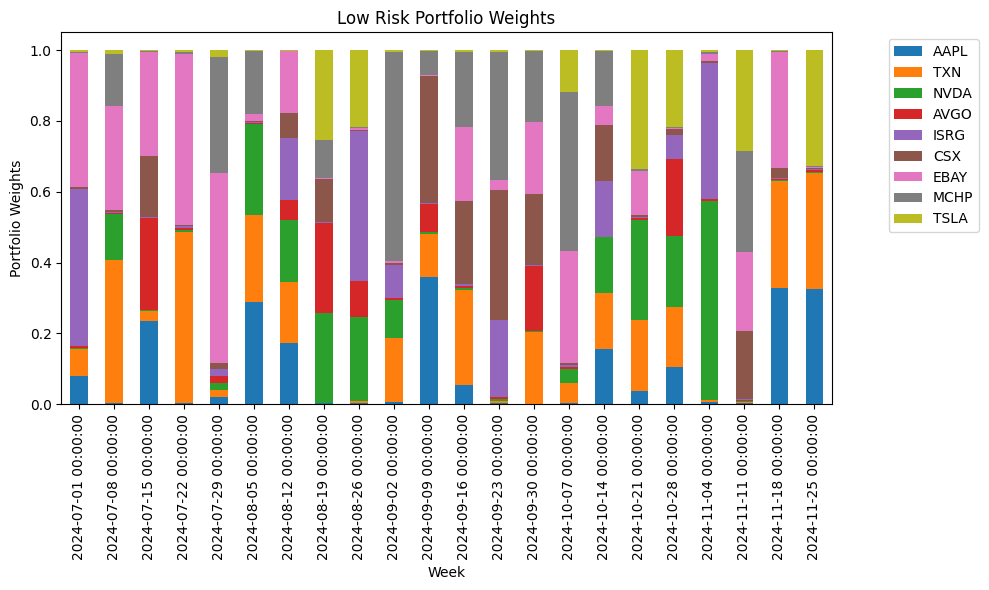

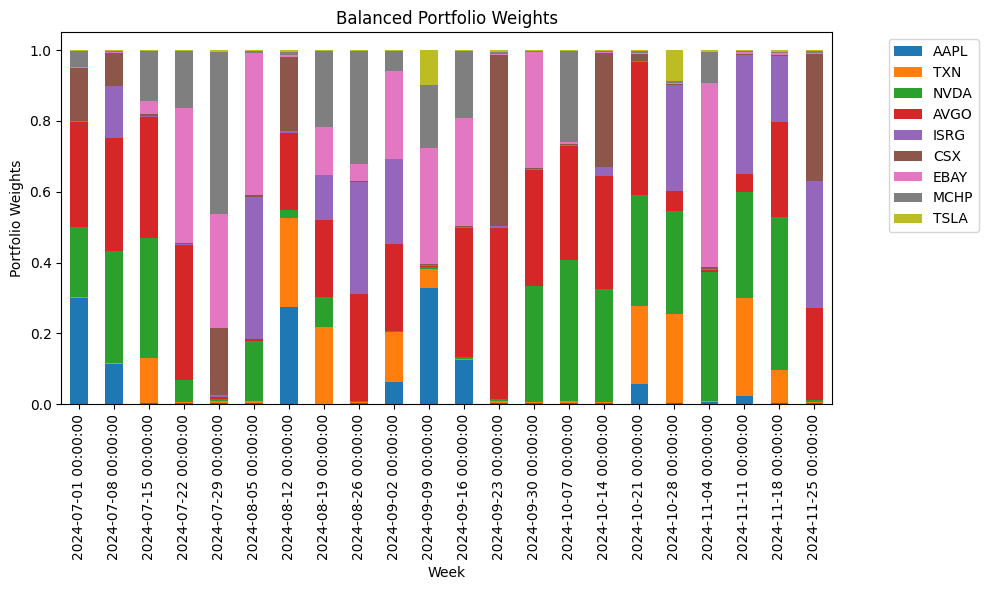

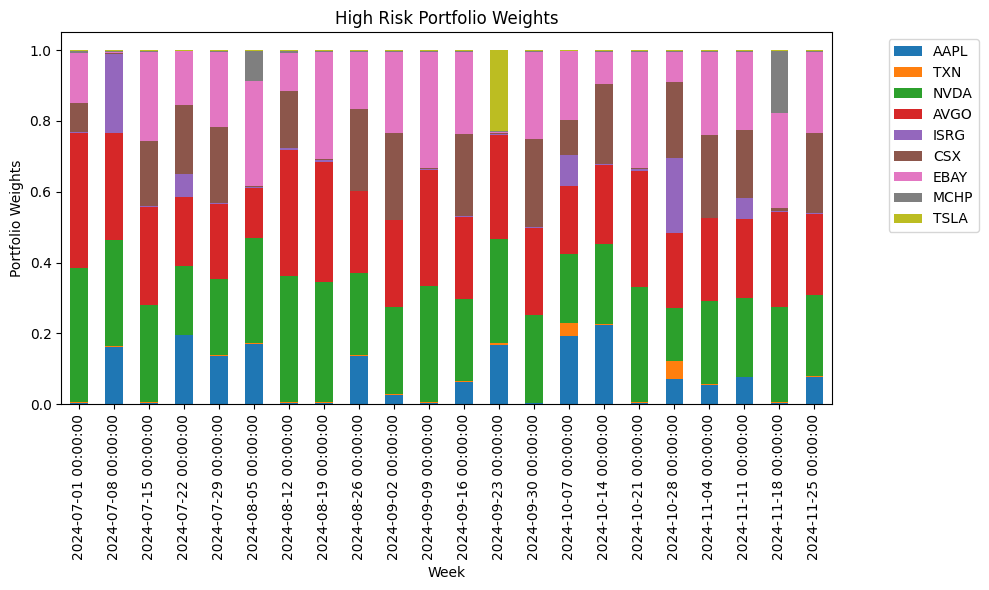

Vizualizációk elkészültek és mentve a megfelelő fájlokba.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Súlyok betöltése Excel fájlokból
low_risk_weights = pd.read_excel('portfolio_weights_low_risk.xlsx', index_col=0)
balanced_weights = pd.read_excel('portfolio_weights_balanced.xlsx', index_col=0)
high_risk_weights = pd.read_excel('portfolio_weights_high_risk.xlsx', index_col=0)

# Halmozott oszlopdiagram készítése
def plot_stacked_bar(weights, title, output_file):
    weights.plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.title(title)
    plt.xlabel('Week')
    plt.ylabel('Portfolio Weights')
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
    plt.tight_layout()
    plt.savefig(output_file)
    plt.show()

# LOW RISK
plot_stacked_bar(low_risk_weights, 'Low Risk Portfolio Weights', 'low_risk_weights_plot.png')

# BALANCED
plot_stacked_bar(balanced_weights, 'Balanced Portfolio Weights', 'balanced_weights_plot.png')

# HIGH RISK
plot_stacked_bar(high_risk_weights, 'High Risk Portfolio Weights', 'high_risk_weights_plot.png')

print("Vizualizációk elkészültek és mentve a megfelelő fájlokba.")
